In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the dataset

In [3]:
try:
    train_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/train.csv', encoding='latin1')
    test_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/test.csv', encoding='latin1')
except UnicodeDecodeError:
    try:
        train_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/train.csv', encoding='cp1252')
        test_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/test.csv', encoding='cp1252')
    except UnicodeDecodeError:
        train_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/train.csv', encoding='utf-16')
        test_data = pd.read_csv('/content/drive/MyDrive/Applied ML/Data/Assignment 5/Sentiment Analysis/test.csv', encoding='utf-16')


In [4]:
train_data = train_data.dropna(subset=['sentiment'])
test_data = test_data.dropna(subset=['sentiment'])

# Preparing the dataset

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = data.text
        self.labels = data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.labels[item]

        # Ensure label is a string and properly mapped
        label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        if isinstance(label, str):
            numeric_label = label_mapping.get(label.lower().strip(), -1)  # Use get to handle unexpected labels
        else:
            numeric_label = label  # Assuming label is already numeric, ensure it's within expected range

        # Check if label is outside expected range
        if numeric_label not in label_mapping.values():
            raise ValueError(f"Unexpected label value: {label} at index {item}")

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(numeric_label, dtype=torch.long)
        }


# Parameters

In [6]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

# Tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Dataset and DataLoader

In [8]:
train_dataset = SentimentDataset(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SentimentDataset(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model


In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Optimizer & Scheduler

In [10]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training Loop


In [11]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation Function


In [12]:
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Running the training and evaluation


In [13]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'Train loss {train_loss}, accuracy {train_acc}')

    test_acc, test_loss = eval_model(model, test_loader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f'Test loss {test_loss}, accuracy {test_acc}')


Epoch 1/3


100%|██████████| 1718/1718 [09:22<00:00,  3.05it/s]


Train loss 0.557155820978014, accuracy 0.7689676503766238


100%|██████████| 221/221 [00:26<00:00,  8.40it/s]


Test loss 0.49246002302180586, accuracy 0.7911714770797963
Epoch 2/3


100%|██████████| 1718/1718 [09:19<00:00,  3.07it/s]


Train loss 0.36987849735634293, accuracy 0.853535169753648


100%|██████████| 221/221 [00:26<00:00,  8.34it/s]


Test loss 0.49531385899264346, accuracy 0.789756649688738
Epoch 3/3


100%|██████████| 1718/1718 [09:19<00:00,  3.07it/s]


Train loss 0.24421671638834455, accuracy 0.9104472180779447


100%|██████████| 221/221 [00:26<00:00,  8.37it/s]

Test loss 0.5793197816279949, accuracy 0.7911714770797963


# Classification Report


In [15]:
def get_predictions(model, data_loader, device):
    model = model.eval()
    texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            texts.extend(texts)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    classification_report_dict = classification_report(real_values, predictions, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
    return classification_report_dict

In [16]:
final_report = get_predictions(model, test_loader, device)
print(final_report)

{'Negative': {'precision': 0.7758284600389863, 'recall': 0.7952047952047953, 'f1-score': 0.785397138628515, 'support': 1001}, 'Neutral': {'precision': 0.7589348283111422, 'recall': 0.7573426573426574, 'f1-score': 0.7581379068953449, 'support': 1430}, 'Positive': {'precision': 0.8482886216466234, 'recall': 0.8313689936536718, 'f1-score': 0.8397435897435896, 'support': 1103}, 'accuracy': 0.7911714770797963, 'macro avg': {'precision': 0.7943506366655839, 'recall': 0.7946388154003747, 'f1-score': 0.7944262117558165, 'support': 3534}, 'weighted avg': {'precision': 0.7916082180702275, 'recall': 0.7911714770797963, 'f1-score': 0.7913290668122994, 'support': 3534}}


# Plotting


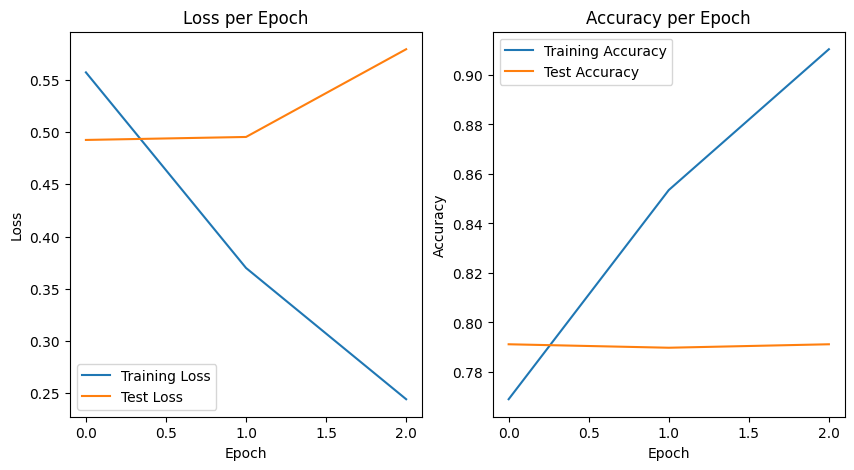

In [24]:
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()